# Generating Blue Noise


## Initialization

the `size` controls the width/eight of the square image we are generating.
`SIGMA` determines the radius that is used to estimate the clustering density later in the algorithm.
It will influence the randomness of resulting noise and higher `SIGMA` values will lead higher calculation and memory costs.
The `ranks` array will contain the generated noise in the end.


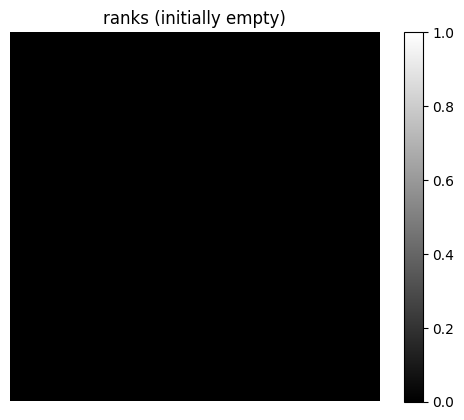

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from scipy.fft import fft2, fftshift

size = 128
SIGMA = 2

# Initilize empty array to contain the result
ranks = np.zeros((size, size), dtype=np.int32)

### PLOT ###
plt.title("ranks (initially empty)")
plt.figure(1)
plt.axis("off")
plt.imshow(ranks, cmap="grey", vmin=0, vmax=1)
plt.colorbar()

## Step 1

We generate white noise and threshold it to randomly select about 10% of the pixels from the image.


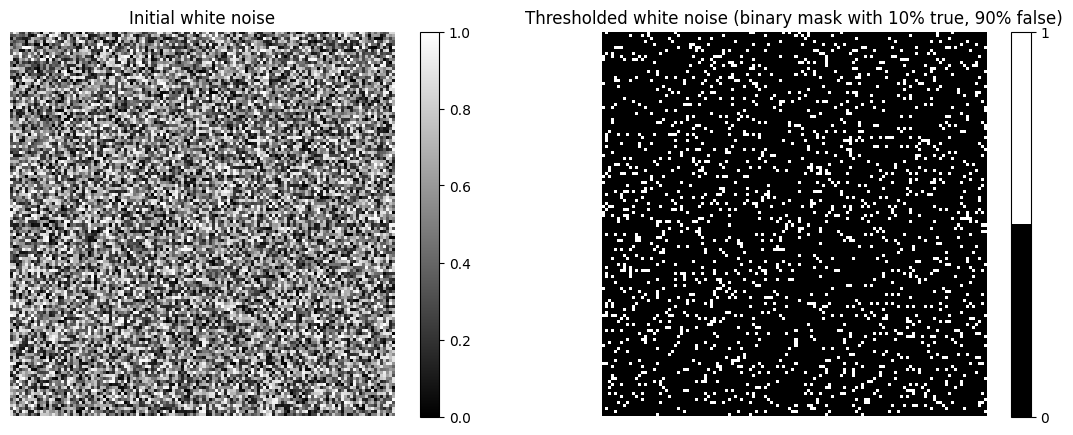

In [85]:
# Make this notebook deterministic
np.random.seed(23)

# Generate white noise array in the size of the resulting image
initial_white_noise = np.random.rand(size, size)

# Threshold to get boolean array with 10% of the pixels set to true
initial_10_percent_white = initial_white_noise > 0.9

### PLOT ###
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1, title="Initial white noise")
plt.axis("off")
plt.imshow(initial_white_noise, cmap="grey", vmin=0, vmax=1)
plt.colorbar()
plt.subplot(
    1, 2, 2, title="Thresholded white noise (binary mask with 10% true, 90% false)"
)
plt.axis("off")
plt.imshow(initial_10_percent_white, vmin=0, vmax=1, cmap=plt.get_cmap("grey", 2))
plt.colorbar(ticks=[1, 0])

# Step 2: Swap pixels to make the image more uniform

The currently selected pixels are randomly spread across the image but by the nature of white noise
they may form clumps/clusters in some places and empty spots/voids in other places.

In this step we adjust our selection by swapping selected pixels in dense areas with not-selected pixels in void areas, until the density is uniform enough.


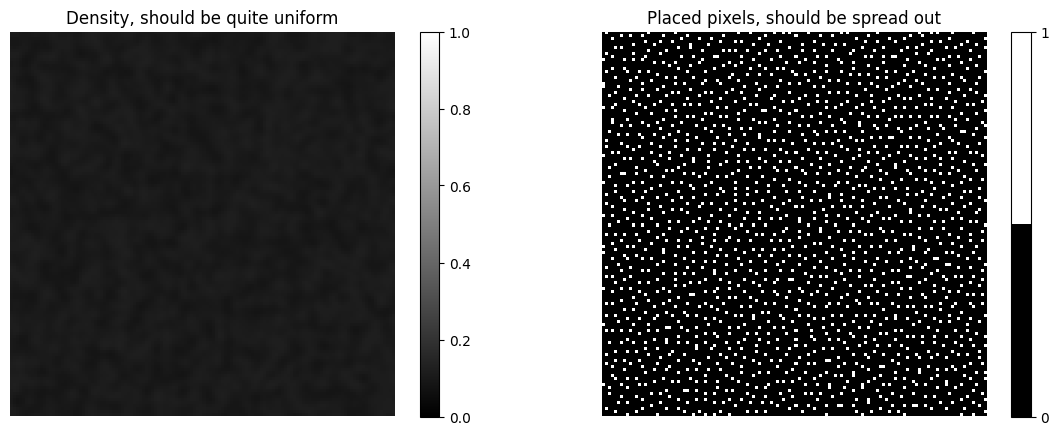

In [86]:
# Create a copy of the boolean array that has 10% of the pixels set to true
phase1 = initial_10_percent_white.copy()

# memory for cycle detection
prev = None

# Repeat until distribution of pixels is even
while True:
    # Estimate the density per pixel by applying a blur filter, to the set of selected pixels
    blurred = gaussian(phase1, sigma=SIGMA, mode="wrap")

    # Select the pixel (that is already set to true) from the denses area
    densest = (blurred * phase1).argmax()
    # and the pixel (that is not yet set to true) from the sparsest area
    voidest = blurred.argmin()

    # try to detect a cycle (if the same selection in reserve was made in the last iteration)
    if prev == (voidest, densest):
        break
    if densest == voidest:
        break

    # argmin/argmax return 1d indicies, convert them back to 2d index pair
    densest_coord = np.unravel_index(densest, phase1.shape)
    voidest_coord = np.unravel_index(voidest, phase1.shape)

    # swap the densest with the sparsest pixel
    phase1[densest_coord] = False
    phase1[voidest_coord] = True

    # remember which pixels had been swapped for next iteration
    prev = (densest, voidest)

### PLOT ###
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1, title="Density, should be quite uniform")
plt.axis("off")


plt.imshow(blurred, cmap="grey", vmin=0, vmax=1)
plt.colorbar()
plt.subplot(1, 2, 2, title="Placed pixels, should be spread out")
plt.axis("off")


plt.imshow(phase1, vmin=0, vmax=1, cmap=plt.get_cmap("grey", 2))
plt.colorbar(ticks=[1, 0])

# Step 3: Assign unique values

Now that we have a uniformly spread set of pixel locations in the image, we want to assign each of these pixels a distinct values.

We do this by iterating through the pixels in a deterministic order: from densest area to sparses.
In each step we blur the image. Determine the pixel of highest density and remove it from the set.
Assign a new intesity/rank value to this pixel in the resulting image.
Repeat until all pixels have been removed.


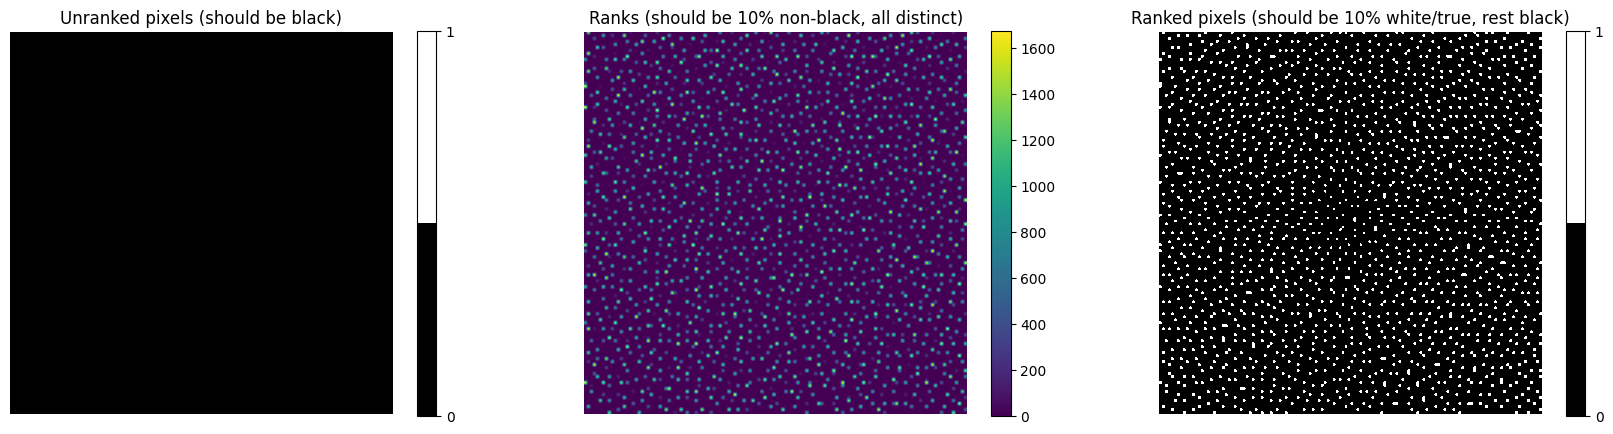

In [87]:
# Create a copy of the pixel selection to not destroy the original in this step
phase2 = phase1.copy()

# Count how many pixel are already set to true
to_remove = np.sum(phase1)

# Set each true pixel back to false, one after another
for rank in range(to_remove, 0, -1):
    # Estimate the density per pixel by applying a blur filter, to the set of selected pixels
    blurred = gaussian(phase2, sigma=SIGMA, mode="wrap")
    # Select the pixel (that is already true) with highest density
    densest = (blurred * phase2).argmax()
    # convert argmax result back to 2d index pair
    densest_coord = np.unravel_index(densest, phase1.shape)

    # set the pixel back to false
    phase2[densest_coord] = False
    # But assign a new (distinct) intensity value at its position in the resulting image
    ranks[densest_coord] = rank


### PLOT ###
plt.figure(figsize=(21, 5))
plt.subplot(1, 3, 1, title="Unranked pixels (should be black)")
plt.axis("off")
plt.imshow(phase2, vmin=0, vmax=1, cmap=plt.get_cmap("grey", 2))
plt.colorbar(ticks=[0, 1])

plt.subplot(1, 3, 2, title="Ranks (should be 10% non-black, all distinct)")
plt.axis("off")
plt.imshow(ranks, vmin=0, cmap="viridis")
plt.colorbar()

plt.subplot(1, 3, 3, title="Ranked pixels (should be 10% white/true, rest black)")
plt.axis("off")
plt.imshow(phase1, vmin=0, vmax=1, cmap=plt.get_cmap("grey", 2))
plt.colorbar(ticks=[1, 0])

## Step 4: Select more pixels

Until now only 10% of the pixels had been selected and processed.
Now we want to assign distinct intsities to all the remaining pixels.

We do this similar as before but the other way around:
Select a pixel that has no rank/intensity yet from the sparsest spot in the map of ranked pixels. Assign its the next available inteisity value and add it to the set of ranked pixels.
Repeat until all pixels are ranked.

The original void+cluster algorithm splits this step into two, by first filling up 50% of the pixels and then in a second step processing the remaining 50%. But I do not see why this would be necessary.


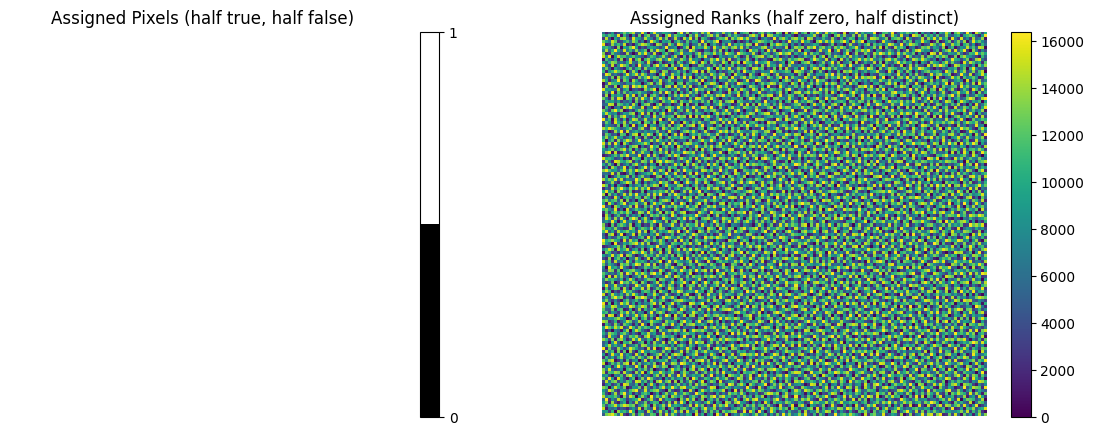

In [88]:
# Create another copy of the pixel selection from step one
# All the pixels that were reset back to false in the previous step
# are still set to true in this copy.
phase3 = phase1.copy()

# Count how many pixels are still black/false,
# ie. have not been selected yet,
# ie. have no intensity/rank assigned to them yet
to_add = phase1.size - np.sum(phase1)
# Start one above the highest rank/intensity value that has been assigned yet
start_from_rank = to_remove + 1  # alternatively: np.max(ranks) + 1

# Iterate until all pixels of the resulting image are filled
for rank in range(to_add):
    # Estimate the density per pixel by applying a blur filter, to the set of selected pixels
    blurred = gaussian(phase3, sigma=SIGMA, mode="wrap")
    # Select the pixel (that had not been selected yet) from the sparsest/voidest area
    voidest = (blurred + phase3).argmin()
    # convert the argmin result into 2d coordinate pair
    voidest_coord = np.unravel_index(voidest, phase3.shape)

    # Set the pixel to true to mark it as already selected/processed
    phase3[voidest_coord] = True
    # Assign a new (distinct) rank/intesity value to its position in the resulting image
    ranks[voidest_coord] = start_from_rank + rank

### PLOT ###
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1, title="Assigned Pixels (half true, half false)")
plt.axis("off")
plt.imshow(phase3, vmin=0, vmax=1, cmap=plt.get_cmap("grey", 2))
plt.colorbar(ticks=[1, 0])

plt.subplot(1, 2, 2, title="Assigned Ranks (half zero, half distinct)")
plt.axis("off")
plt.imshow(ranks, vmin=0, cmap="viridis")
plt.colorbar()

## Result

The final rank image should now contain distinct inteisity values for all the pixels. And all similar intensities should be distributed well across the image.


In [89]:
# This is the redundant step of the original algorithm the processes
# the second half of the remaining pixels separatly:

# phase4 = phase3.copy()
#
# to_add = phase3.size - np.sum(phase3)
# start_from_rank = np.max(ranks) + 1
#
# for rank in range(to_add):
#     inverted = 1 - phase4
#     blurred = gaussian(inverted, sigma=SIGMA, mode="wrap")
#     voidest = (inverted * blurred).argmax()
#     voidest_coord = np.unravel_index(voidest, phase4.shape)
#     phase4[voidest_coord] = True
#     ranks[voidest_coord] = start_from_rank + rank
#
# plt.figure(figsize=(14, 5))
# plt.subplot(1, 2, 1, title="Assigned Pixels (all should be white/true)")
# plt.axis("off")
#
# plt.imshow(phase4, vmin=0, vmax=1, cmap=plt.get_cmap("grey", 2))
#
# plt.colorbar(ticks=[0, 1])
# plt.subplot(1, 2, 2, title="Assigned Ranks (all should be distinct)")
# plt.axis("off")
#
# plt.imshow(ranks, vmin=0, vmax=ranks.size)
#
# plt.colorbar()

## Inspecting the results

Now that we have an image consisting of nicely spread intensity values we can apply some tests to observe the blue noise characteristic.

The apply the 2D discrete fourier transform (DFT) to calculate the power spectral density and observe that the center area (representing low frequencies) is dark.


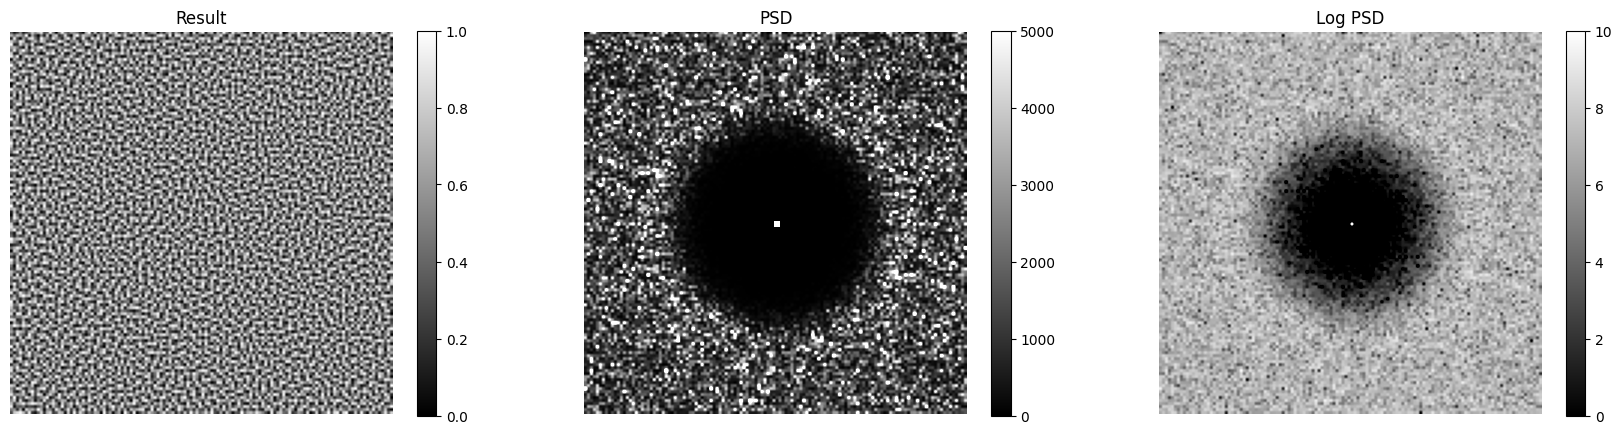

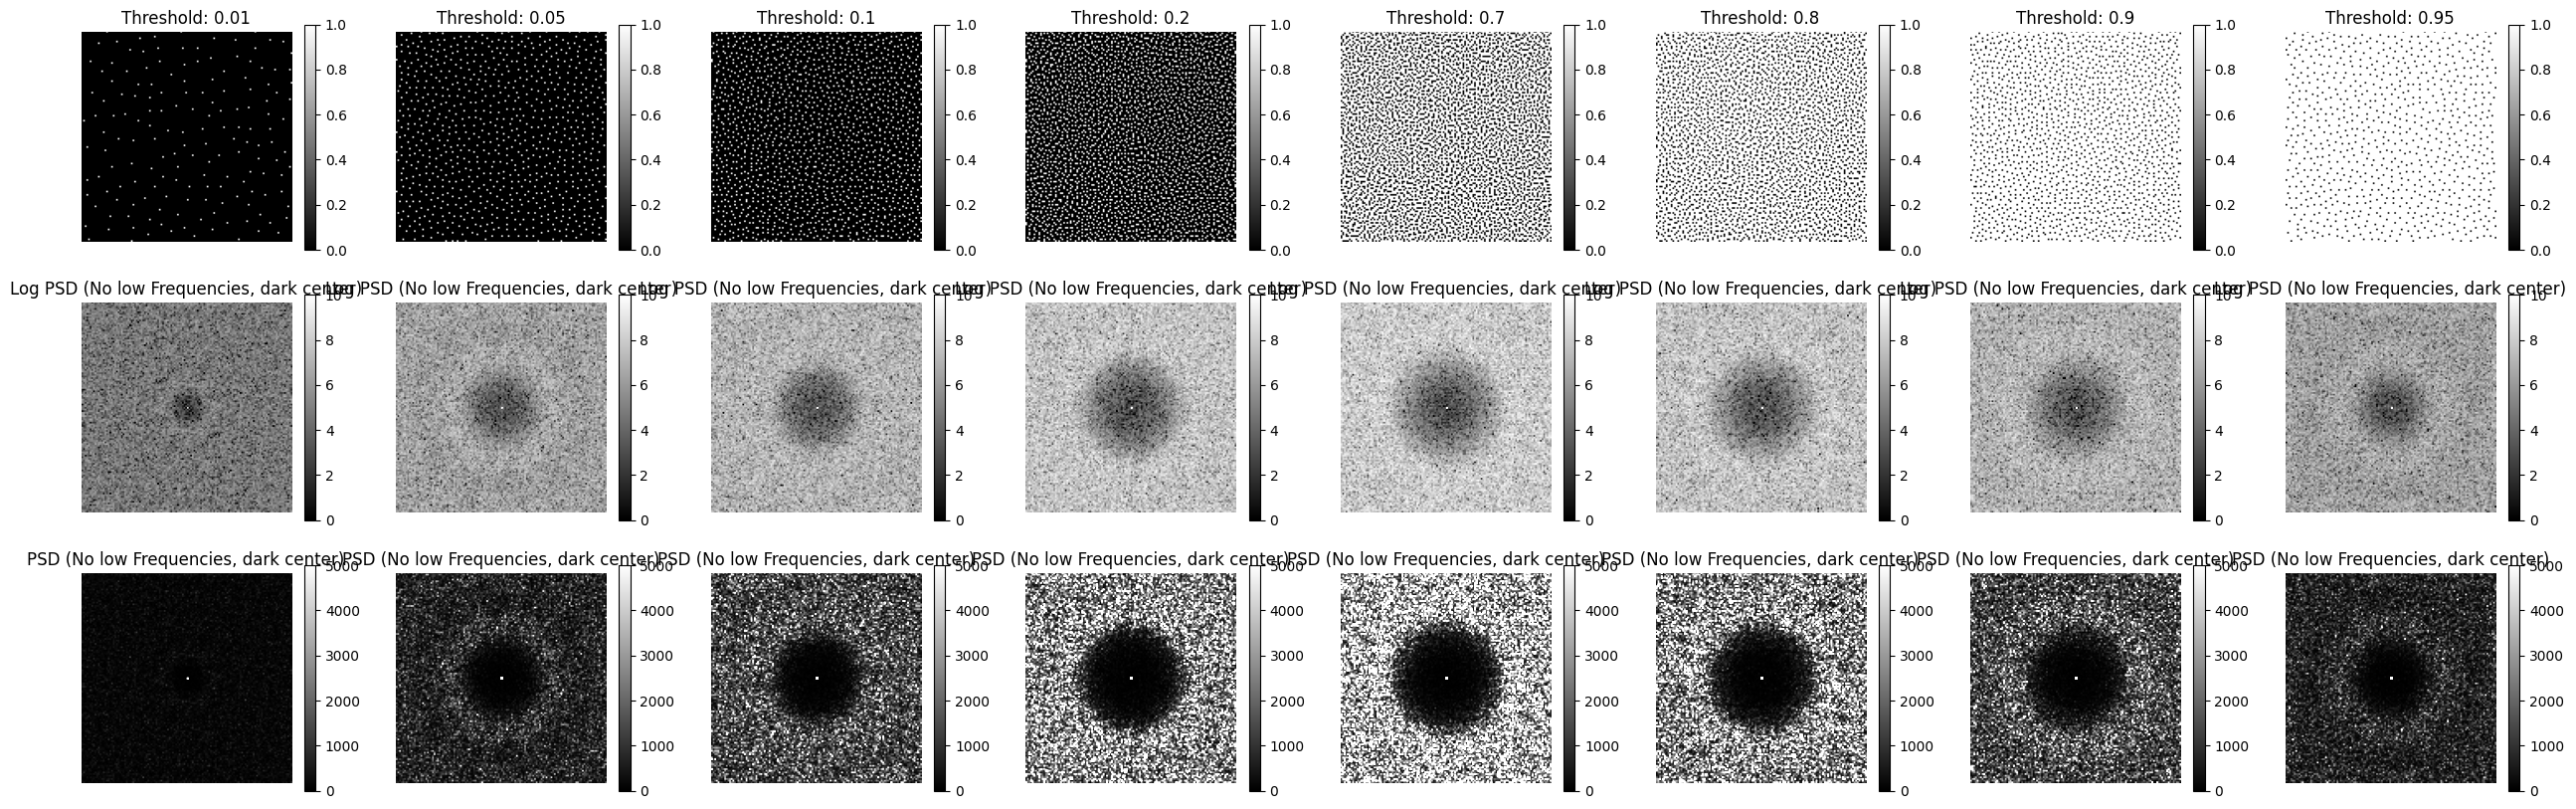

In [90]:
# Convert distinct rank values into range between 0 and 1
results = ranks / ranks.size

# The smallest number that can be represented by floating point numbers
# is used as offset to prevent division by 0 or log(0)
eps = np.finfo(float).eps

# Calculate the 2d fourier transform of the image to obtain its frequency spectrum
fft = fft2(results)
psd = np.abs(fftshift(fft)) ** 2
log_psd = np.log(psd + eps)

plt.figure(1, figsize=(21, 5))
plt.subplot(1, 3, 1, title=f"Result")
plt.imshow(results, cmap="grey", vmin=0)
plt.colorbar()
plt.axis("off")

plt.subplot(1, 3, 2, title=f"PSD")
plt.imshow(psd, cmap="grey", vmin=0, vmax=5000)
plt.colorbar()
plt.axis("off")

plt.subplot(1, 3, 3, title=f"Log PSD")
plt.imshow(log_psd, cmap="grey", vmin=0, vmax=10)
plt.colorbar()
plt.axis("off")

# Convert the image back into binary images by thresholding (by various different values)
# and calculate the PSD and Log-PSD for each
thresholds = [0.01, 0.05, 0.1, 0.2, 0.7, 0.8, 0.9, 0.95]
thresholded_images = list(map(lambda t: results < t, thresholds))
thresholded_psds = list(
    map(lambda t: fftshift(np.abs(fft2(t.astype(np.float32))) ** 2), thresholded_images)
)
thresholded_log_psds = list(map(lambda t: np.log(t + eps), thresholded_psds))

### PLOT ###
plt.figure(2, figsize=(len(thresholds) * 4, 10))
cols = len(thresholds)

for i, (t, img, psd, logpsd) in enumerate(
    zip(thresholds, thresholded_images, thresholded_psds, thresholded_log_psds), 1
):
    plt.subplot(3, cols, i + (2 * cols), title="PSD (No low Frequencies, dark center)")
    plt.imshow(psd, cmap="grey", vmin=0, vmax=5000)
    plt.colorbar()
    plt.axis("off")

    plt.subplot(
        3, cols, i + (1 * cols), title="Log PSD (No low Frequencies, dark center)"
    )
    plt.imshow(logpsd, cmap="grey", vmin=0, vmax=10)
    plt.colorbar()
    plt.axis("off")

    plt.subplot(3, cols, i + (0 * cols), title=f"Threshold: {t}")
    plt.imshow(img, cmap="grey", vmin=0, vmax=1)
    plt.colorbar()
    plt.axis("off")

## Apply to convolution

Now that we have created a blue noise texture we can use it as a random number "generator", ie. a source for pseudo random numbers.

One interesting use-case is to replace a classic convolution with stochatic sampling.
In a classic convolution a window is moved across an image (signal) and for each position a weighted sum of the image pixels is calculated. The convolution kernel contains the specific weights that are used.
When using stochastic sampling the weighted sum is replaced by interpreting the kernel weights as probability distribution.
Instead of multiplying each overlapping pixel with a weight and summing all the results, per window position only a single image pixel (or some limited number) is selected randomly according to the probability distribution that is described by the kernel weights.

For a gaussian kernel this leads to a similar (but different) blurring of the image.

Now that the image is sampled randomly not only the shape of the kernel but also the source of randomness influences the result. We can try this out by using our generated blue noise as source of randomness and compare it to a simple white noise random variable.


In [91]:
# This functions takes a discrete convolution kernel as probability distribution and samples it
# with a given source of randomness.
# w and h are the dimensions of an image the kernel should be applied to in the end.
# The random_source is a 2d image containg random values. between 0 and 1.
# It returns two tuples:
#  1. a tuple of arrays containing x and y indices into an (w*h) sized imaged that are randomly
#     (according to the kernel and random_source) offset
#  2. a tuple of arrays containing only the random offsets for each pixel in a (w*h) sized image
def precompute_stochstic_indices(width, height, kernel, random_source):
    # Calculate 1-dimensional Cumulative distribution of the kernel.
    # This is not(!) the actual 2D CDF.
    # This 1d-conversion assumes that the kernel is a discrete probability distribution
    # By converting it into a 1d CDF we can sample the distribution using a uniform random value
    cumulative_kernel = np.cumsum(kernel.ravel()) / np.sum(kernel)

    # Create arrays of all possible indices (ie. pixel positions)
    # in an image of the given size
    xv, yv = np.indices((width, height))

    # The size of the image that acts as pseudo random number source
    random_w, random_h = random_source.shape

    # assign a random value from the random_source to each pixel in the target image
    # The way this is done (using the target coordinates as indices into the random_source)
    # the spatial correlation between the values in the random_source
    # is preserved/transferred to the target image
    random_values = random_source[xv % random_w, yv % random_h].ravel()

    # Sample the kernel distribution using the generated random values
    # This is done by selecting the position in the cumulative_kernel
    # whose cumulative value is closest to the random number
    # This assumes that both the random numbers from the random_source
    # and the cumulative_kernel contain values in the same range (0,1)
    kernel_sample = np.argmin(
        np.abs(np.subtract.outer(random_values, cumulative_kernel)), axis=1
    ).reshape(width, height)

    # Convert the argmin result back into 2d coordinates
    offset_x, offset_y = np.unravel_index(kernel_sample, kernel.shape)

    # Offset the positions by half the kernel size
    rel_x = offset_x - kernel.shape[0] // 2
    rel_y = offset_y - kernel.shape[1] // 2

    # Return both...
    return (
        # the absolute coordinates
        ((xv + rel_x) % width, (yv + rel_y) % height),
        # And the relative offsets
        (rel_x, rel_y),
    )

In [106]:
from skimage import data, color, filters
import scipy
import time

# Use generated blue noise
blue_noise = ranks / np.max(ranks)
# Generate fresh white noise
white_noise = np.random.rand(*ranks.shape)

# Load example image
astro = color.rgb2gray(data.astronaut())


def centered_one(size):
    arr = np.zeros((size, size))
    arr[size // 2, size // 2] = 1
    return arr


# Various sigma values to try for the gaussian kernel
sigmas = [1, 2, 3, 5, 7]
filter_sizes = list(map(lambda sig: 8 * sig + 1, sigmas))
filter_arrays = list(map(lambda s: centered_one(s), filter_sizes))
kernels = list(
    map(lambda arr, sig: filters.gaussian(arr, sigma=sig), filter_arrays, sigmas)
)
cum_kernels = list(
    map(lambda k: (np.cumsum(k.ravel()) / np.sum(k)).reshape(k.shape), kernels)
)

# The different kinds of convolution to calculate
algos = [
    (
        "Classic Conv",  # Classic convolution
        lambda k: scipy.signal.convolve2d(astro, k, mode="same", boundary="wrap"),
        None,
    ),
    (
        "SSPP White",  # Replace convolution with single pixel sampling, use WHITE noise as
        # random source, and the kernel as distribution to sample the pixel from
        lambda k: astro[precompute_stochstic_indices(*astro.shape, k, white_noise)[0]],
        lambda k: precompute_stochstic_indices(*astro.shape, k, white_noise)[1],
    ),
    (
        "SSPP Blue",  # Replace convolution with single pixel sampling, use BLUE noise as
        # random source, and the kernel as distribution to sample the pixel from
        lambda k: astro[precompute_stochstic_indices(*astro.shape, k, blue_noise)[0]],
        lambda k: precompute_stochstic_indices(*astro.shape, k, blue_noise)[1],
    ),
]

In [114]:
# Calculate and collect all combinations between the 3 algos and 5 sigma values
combinations = []
offset_combos = []
for p, (sigma, kernel) in enumerate(zip(sigmas, kernels), 1):
    combs = []
    off = []
    for a, (name, fn, offset_fn) in enumerate(algos):
        tic = time.time()
        result = fn(kernel)
        toc = time.time()

        combs.append((result, toc - tic))

        if offset_fn is not None:
            off.append(np.linalg.norm(offset_fn(kernel), axis=0))
        else:
            off.append(None)

    combinations.append(combs)
    offset_combos.append(off)

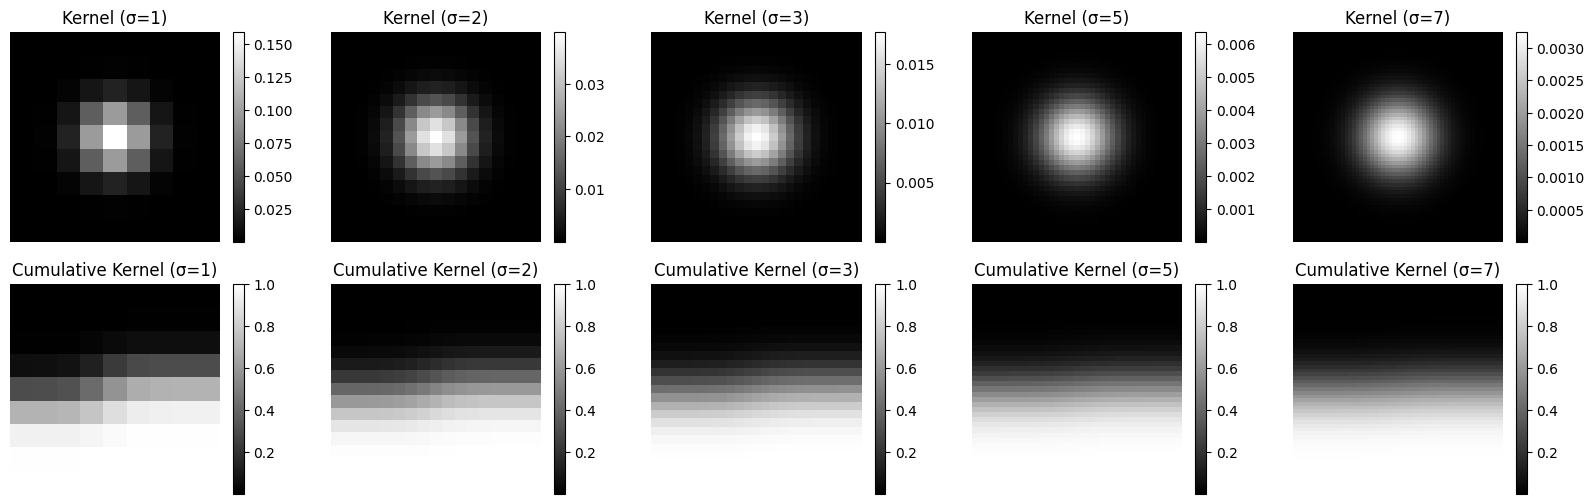

In [111]:
### PLOT ###
# Plot the kernels and the cumulative variants that are used to sample from
plt.figure(0, figsize=(20, 6))
for p, (sigma, kernel, cum_kernel) in enumerate(zip(sigmas, kernels, cum_kernels), 1):
    plt.subplot(2, len(sigmas), p, title=f"Kernel (σ={sigma})")
    plt.imshow(kernel, cmap="gray")
    plt.axis("off")
    plt.colorbar()

    plt.subplot(2, len(sigmas), p + len(sigmas), title=f"Cumulative Kernel (σ={sigma})")
    plt.imshow(cum_kernel, cmap="gray")
    plt.axis("off")
    plt.colorbar()

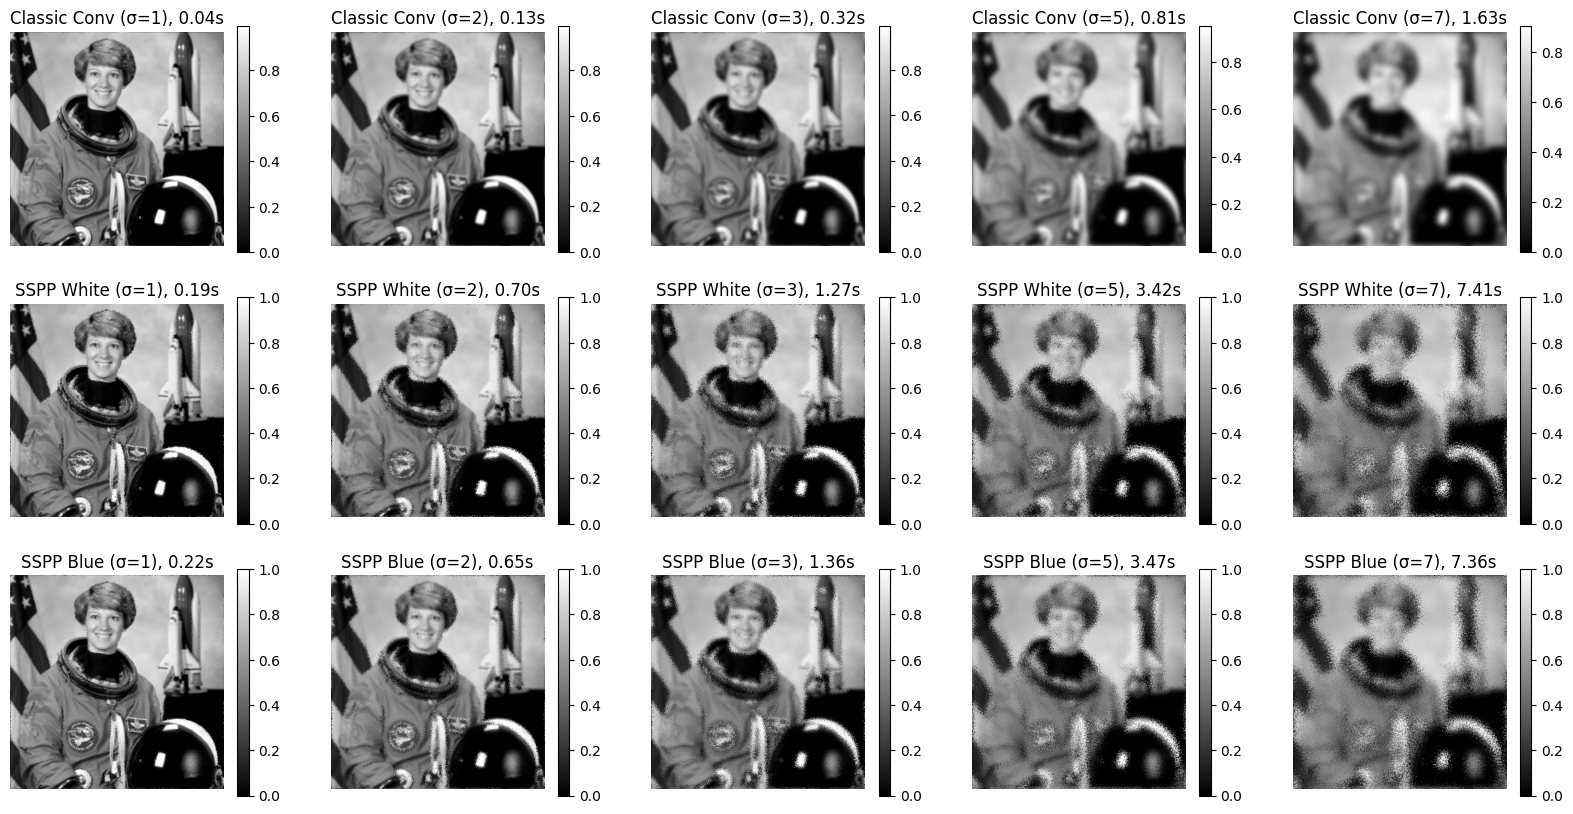

In [112]:
### PLOT ###
# Plot the resulting images for all combinations of algorithms and kernels
plt.figure(1, figsize=(20, 10))
for p, (sigma, kernel, comb) in enumerate(zip(sigmas, kernels, combinations), 1):
    for a, ((name, fn, _), (result, t)) in enumerate(zip(algos, comb)):
        plt.subplot(
            len(algos),
            len(sigmas),
            p + a * len(sigmas),
            title=f"{name} (σ={sigma}), {t:.2f}s",
        )
        plt.imshow(result, cmap="gray")
        plt.axis("off")
        plt.colorbar()

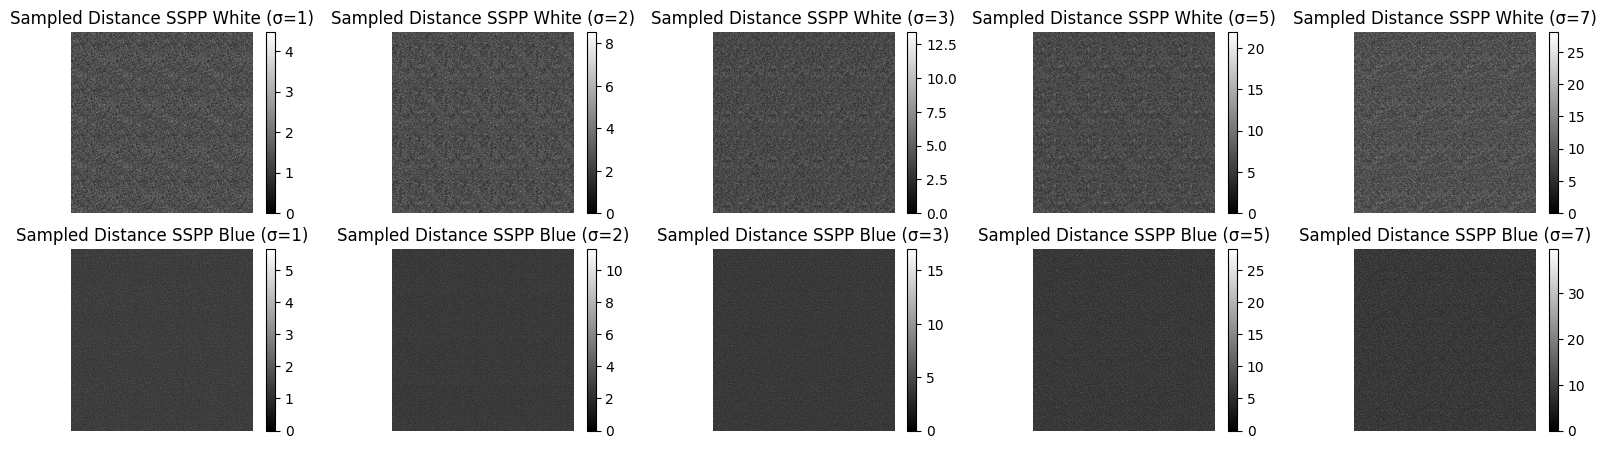

In [115]:
### PLOT ###
# Plot the magnitude of the offset the was sampled per pixel
plt.figure(2, figsize=(20, 8))
for p, (sigma, kernel, offsets) in enumerate(zip(sigmas, kernels, offset_combos), 1):
    for a, ((name, _, _), offset) in enumerate(zip(algos, offsets)):
        if offset is None:
            continue

        plt.subplot(
            len(algos),
            len(sigmas),
            p + a * len(sigmas),
            title=f"Sampled Distance {name} (σ={sigma})",
        )
        plt.imshow(offset, cmap="gray")
        plt.axis("off")
        plt.colorbar()